In [1]:
import tifffile
import imageio

slope = tifffile.imread('slope.tif')
viento = tifffile.imread('viento.tif')
ndvi = tifffile.imread('ndvi.tif')
png = imageio.imread('moncayo.png')

print(slope.shape, viento.shape, ndvi.shape, png.shape)

/tmp/ipykernel_12734/963767348.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  png = imageio.imread('moncayo.png')


(3601, 3601) (3601, 3601, 2) (3602, 3602) (3602, 3602, 3)


In [36]:
# convert ndvi to kg/ha as per Table 1 in https://www.jstage.jst.go.jp/article/jass/32/4/32_133/_pdf/-char/ja
fuel_load = 13231.58 * ndvi - 6093.07
# convert kg/ha to lb/ft as per https://www.wolframalpha.com/input?i=kg%2Fha+to+lb%2Fft%5E2
fuel_load *= 2.048e-5
# divide per ft^2
fuel_load /= 322.9 # https://www.wolframalpha.com/input?i=30m%5E2+to+ft
# negative values do not make sense
fuel_load[fuel_load < 0] = 0.0

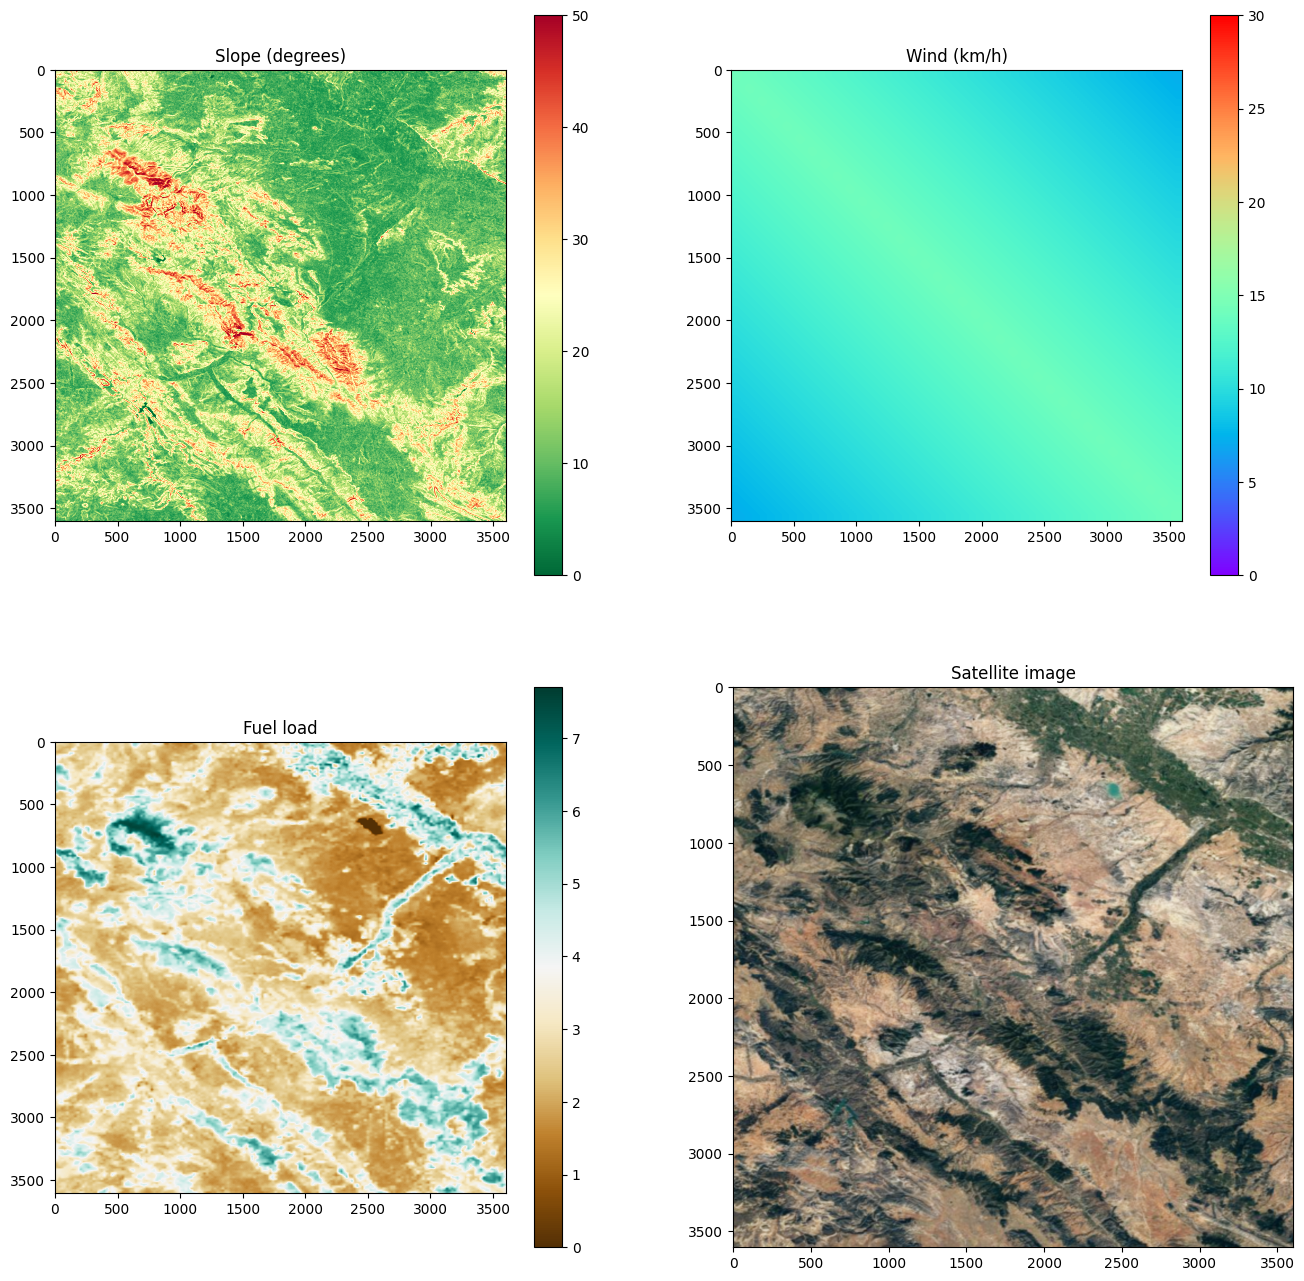

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(16, 16))

axs[0, 0].set_title('Slope (degrees)')
mappable = axs[0, 0].imshow(slope, cmap='RdYlGn_r', vmin=0, vmax=50)
fig.colorbar(mappable, ax=axs[0, 0])

axs[0, 1].set_title('Wind (km/h)')
mappable = axs[0, 1].imshow(np.linalg.norm(viento, axis=-1) * 10, cmap='rainbow', vmin=0, vmax=30)
fig.colorbar(mappable, ax=axs[0, 1])

axs[1, 0].set_title('Fuel load')
mappable = axs[1, 0].imshow(fuel_load, cmap='BrBG')
fig.colorbar(mappable, ax=axs[1, 0])

axs[1, 1].set_title('Satellite image')
axs[1, 1].imshow(png)

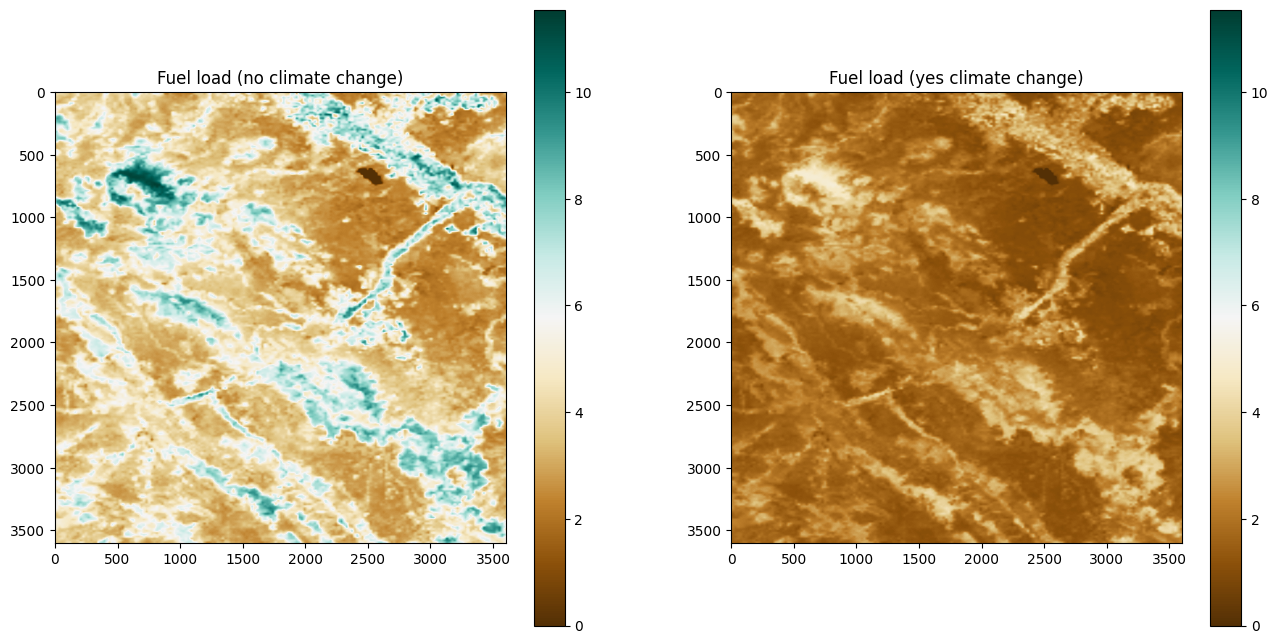

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

fuel_load_max = np.max(fuel_load * 1.5)

axs[0].set_title('Fuel load (no climate change)')
mappable = axs[0].imshow(fuel_load * 1.5, cmap='BrBG', vmin=0, vmax=fuel_load_max)
fig.colorbar(mappable, ax=axs[0])

axs[1].set_title('Fuel load (yes climate change)')
mappable = axs[1].imshow(fuel_load / 1.5, cmap='BrBG', vmin=0, vmax=fuel_load_max)
fig.colorbar(mappable, ax=axs[1])

In [38]:
import math

# Rothermel's fire spread model
# http://www.prairieprojectknowledgehub.org/books/fire/page/rothermels-simple-fire-model
# The Rothermel surface fire model was initially developed for a
# United States Department of Agriculture fire modeling program and used to quantify fire-danger indices.
def GetSimpleFireSpread(fuelload, fueldepth, windspeed, slope, fuelmoisture, fuelsav):
    # Parameters
    maxval= 0
    if fuelload > 0:
        wo = fuelload # Ovendry fuel loading in (lb/ft^2). Amount of primary prod???
        fd = fueldepth # Fuel depth (ft)
        wv = windspeed * 88# Wind velocity at midflame height (ft/minute) = 88 * mph
        fpsa = fuelsav  # Fuel Particle surface area to volume ratio (1/ft)
        mf = fuelmoisture  # Fuel particle moisture content
        h = 8000  # Fuel particle low heat content
        pp = 32.  # Ovendry particle density
        st = 0.0555  # Fuel particle mineral content
        se = 0.010  # Fuel Particle effective mineral content
        mois_ext = 0.12  # Moisture content of extinction or 0.3 if dead
        #calculate slope as degrees
        slope_rad = math.atan(slope)
        slope_degrees = slope_rad / 0.0174533 #radians
        tan_slope = math.tan(slope_rad) #  in radians
        # Betas Packing ratio
        Beta_op = 3.348 * math.pow(fpsa, -0.8189)  # Optimum packing ratio
        ODBD = wo / fd  # Ovendry bulk density
        Beta = ODBD / pp #Packing ratio
        #Beta = 0.00158
        Beta_rel = Beta / Beta_op
        # Reaction Intensity
        WN = wo / (1 + st)  # Net fuel loading
        #A = 1 / (4.774 * pow(fpsa, 0.1) - 7.27)  # Unknown const
        A =  133.0 / math.pow(fpsa, 0.7913) #updated A
        T_max = math.pow(fpsa,1.5) * math.pow(495.0 + 0.0594 * math.pow(fpsa, 1.5),-1.0)  # Maximum reaction velocity
        #T_max = (fpsa*math.sqrt(fpsa)) / (495.0 + 0.0594 * fpsa * math.sqrt(fpsa))
        T = T_max * math.pow((Beta / Beta_op),A) * math.exp(A * (1 - Beta / Beta_op))  # Optimum reaction velocity
        # moisture dampning coefficient
        NM = 1. - 2.59 * (mf / mois_ext) + 5.11 * math.pow(mf / mois_ext, 2.) - 3.52 * math.pow(mf / mois_ext,3.)  # Moisture damping coeff.
        # mineral dampning
        NS = 0.174 * math.pow(se, -0.19)  # Mineral damping coefficient
        #print(T, WN, h, NM, NS)
        RI = T * WN * h * NM * NS
        #RI = 874
        # Propogating flux ratio
        PFR = math.pow(192.0 + 0.2595 * fpsa, -1) * math.exp(
            (0.792 + 0.681 * fpsa ** 0.5) * (Beta + 0.1))  # Propogating flux ratio
        ## Wind Coefficient
        B = 0.02526 * math.pow(fpsa, 0.54)
        C = 7.47 * math.exp(-0.1333 * math.pow(fpsa, 0.55))
        E = 0.715 * math.exp(-3.59 * 10**-4 * fpsa)
        #WC = C * wv**B * math.pow(Beta / Beta_op, -E) #wind coefficient
        if wv > (0.9 * RI): #important - don't know source. Matches BEHAVE
            wv = 0.9 * RI
        WC = (C * wv ** B) * math.pow((Beta / Beta_op), (-E))
        #WC= WC*0.74
        #Slope  coefficient
        SC = 5.275*(Beta**-0.3)*tan_slope**2
        #Heat sink

        EHN = math.exp(-138. / fpsa)  # Effective Heating Number = f(surface are volume ratio)
        QIG = 250. + 1116. * mf  # Heat of preignition= f(moisture content)
        # rate of spread (ft per minute)
        #RI = BTU/ft^2
        numerator = (RI * PFR * (1 + WC + SC))
        denominator = (ODBD * EHN * QIG)
        R = numerator / denominator #WC and SC will be zero at slope = wind = 0
        RT = 384.0/fpsa
        HA = RI*RT
        #fireline intensity as described by Albini via USDA Forest Service RMRS-GTR-371. 2018
        FI = (384.0/fpsa)*RI*(R) ##Uses Reaction Intensity in BTU / ft/ min
        #FI = HA*R
        if (RI <= 0):
            return (maxval, maxval, maxval)
        return (R, RI, FI)
    else:
        return (maxval, maxval, maxval)

In [39]:
import cv2

# desired resolution for the simulation
sx, sy = 200, 200
# desired resolution for output image
ix, iy = 500, 500

slope_res = cv2.resize(slope, (sx, sy))
viento_res = cv2.resize(viento, (sx, sy))
fuel_load_res = cv2.resize(fuel_load, (sx, sy))

png_res = cv2.resize(png, (ix, iy))
imageio.imwrite(f'parsed/moncayo_satellite_{ix}x{iy}.png', png_res)

100%|██████████| 40000/40000 [00:00<00:00, 85096.58it/s]


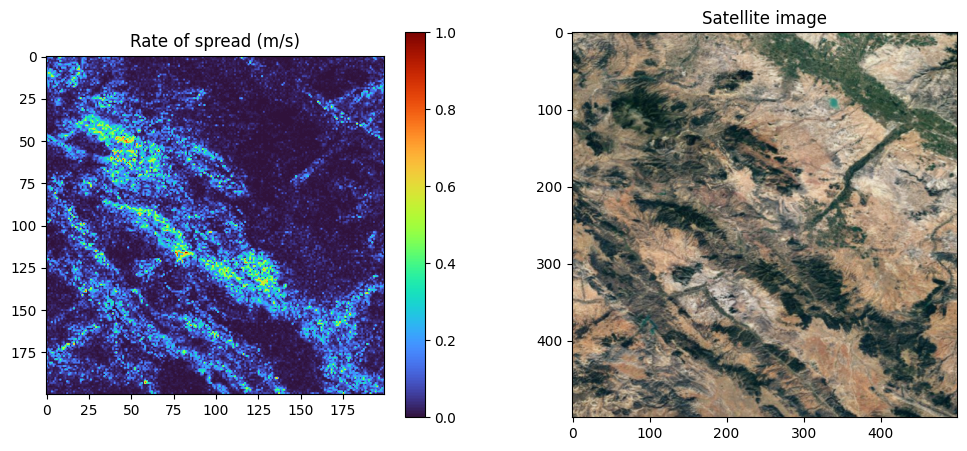

In [64]:
import itertools
from tqdm import tqdm

fire_danger = np.empty((sy, sx), dtype=np.float32)
# fuel depth based on https://essd.copernicus.org/preprints/essd-2022-184/essd-2022-184.pdf
fuel_depth = np.ones((sy, sx), dtype=np.float32) * 1.2
for y, x in tqdm(itertools.product(range(sy), range(sx)), total=sx * sy):
    fire_danger[y, x] = GetSimpleFireSpread(
        fuelload=fuel_load_res[y, x] / 1.5,
        fueldepth=fuel_depth[y, x],
        windspeed=np.linalg.norm(viento[y, x]),
        slope=slope_res[y, x],
        fuelmoisture=0.05, # proportion
        fuelsav=100, # 1/feet
    )[0]  # rate of spread
fire_danger /= np.max(fire_danger)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Rate of spread (m/s)')
mappable = axs[0].imshow(fire_danger, cmap='turbo')
fig.colorbar(mappable, ax=axs[0])
axs[1].set_title('Satellite image')
axs[1].imshow(png_res)
plt.show()

In [65]:
# if convinced, save
tifffile.imwrite(f'parsed/moncayo_firedanger_yescc_{sx}x{sy}.tif', fire_danger)